In [1]:
from ponyge2_adapted_files import Grammar, ge
import algorithms
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools
from sklearn.model_selection import train_test_split
import math
import textwrap
import csv
import random
import json
from parser_files.parser import weight_parser, value_parser

import warnings
warnings.filterwarnings("ignore")

In [2]:
# generate weights for knapsack
NBR_ITEMS = 10
items = dict()
for i in range(NBR_ITEMS):
     items[i] = (random.randint(1, 10), random.randint(1, 100)) 

with open("/mnt/d/college_notes/internship/grape/knapsack_ag/data/knapsack_weights.json", "w") as file:
    json.dump(items, file)


# generate grammar
# for i in range(NBR_ITEMS, 0, -1):
#     print(f"<binaryString_len_{i}>  ::=  0<binaryString_len_{i-1}>|1<binaryString_len_{i-1}>")

In [3]:
GRAMMAR_FILE = 'knapsack.bnf'
BNF_GRAMMAR = Grammar(path.join("/mnt/d/college_notes/internship/grape/grammars", GRAMMAR_FILE))

In [4]:
def fitness_eval(individual, points=None):
    if individual.phenotype is None:
        return np.NaN,
    total_weight = weight_parser(individual.phenotype)
    if total_weight > 200:
        return np.NaN,
    else:
        fitness = -value_parser(individual.phenotype)
        return fitness,

In [9]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))


# creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)
creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)#, points=[X_train, Y_train])

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)


In [17]:
N_RUNS = 32
POPULATION_SIZE = 200
MAX_GENERATIONS = 150
P_CROSSOVER = 0.9
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 12
MIN_INIT_TREE_DEPTH = 11
MAX_TREE_DEPTH = 11
MAX_WRAPS = 0
CODON_SIZE = 255

In [22]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []
bestListSize = []

In [23]:
# population = toolbox.populationCreator(size=POPULATION_SIZE, 
#                                             bnf_grammar=BNF_GRAMMAR, 
#                                             min_init_tree_depth=MIN_INIT_TREE_DEPTH,
#                                             max_init_tree_depth=MAX_INIT_TREE_DEPTH,
#                                             max_tree_depth=MAX_TREE_DEPTH, 
#                                             max_wraps=MAX_WRAPS,
#                                             codon_size=CODON_SIZE
#                                             )

In [24]:
# for ind in (population):
#     print(ind.phenotype, "  len", len(ind.phenotype))

In [26]:
for r in range(0, N_RUNS):
    # create initial population (generation 0):
    population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                            bnf_grammar=BNF_GRAMMAR, 
                                            min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                            max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                            max_tree_depth=MAX_TREE_DEPTH, 
                                            max_wraps=MAX_WRAPS,
                                            codon_size=CODON_SIZE
                                            )
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)             
    # prepare the statistics object:
    #stats = tools.Statistics(key=lambda ind: ind.fitness.values if math.isnan(ind.fitness.values[0]) else None)#ind.fitness.values != np.inf else None)
    #stats = tools.Statistics(key=lambda ind: ind.fitness.values[0] if not math.isnan(ind.fitness.values[0]) else np.NaN)#ind.fitness.values != np.inf else None)
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)# if not ind.invalid else (np.NaN,))#ind.fitness.values != np.inf else None)
    stats.register("avg", np.nanmean)
    stats.register("std", np.nanstd)
    stats.register("min", np.nanmin)
    stats.register("max", np.nanmax)
    
    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)
    # perform the Grammatical Evolution flow:
    population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                          bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                          max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                          points_train=[None, None], 
                                          points_test=[None, None], 
                                          stats=stats, halloffame=hof, verbose=True)

    max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
    min_fitness_values, std_fitness_values = logbook.select("min", "std")
    
    # fitness_test = logbook.select("fitness_test")
    best_ind_length = logbook.select("best_ind_length")
    avg_length = logbook.select("avg_length")
    max_length = logbook.select("max_length")
    # selection_time = logbook.select("selection_time")
    # generation_time = logbook.select("generation_time")
    # gen, invalid = logbook.select("gen", "invalid")ssssss

    # Save statistics for this run:
    avgListFitness.append(mean_fitness_values)
    stdListFitness.append(std_fitness_values)
    minListFitness.append(min_fitness_values)
    maxListFitness.append(max_fitness_values)

    avgListSize.append(avg_length)
    bestListSize.append(best_ind_length)
    # stdListSize.append(stdSizeValues)
    # minListSize.append(minSizeValues)
    maxListSize.append(max_length)

    # best = hof.items[0].phenotype # parser to change the individual 
    best = hof.items[0].phenotype # parser to change the individual
    print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
    print(f"Weight: {weight_parser(best)}") 
    print("\nTraining Fitness: ", -hof.items[0].fitness.values[0])
    print("Depth: ", hof.items[0].depth)
    print("Length of the genome: ", len(hof.items[0].genome))
    print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')                            



Currently on run 0 of 32
gen	invalid	avg     	std    	min	max	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	-20.5256	6.56081	-35	-6 	-35         	15             	15        	15        	0             	0.189638       
1  	11     	-21.9333	6.74553	-36	-7 	-36         	10             	15        	24        	0.00140738    	0.231995       
2  	28     	-22.72  	6.72222	-36	-8 	-36         	10             	15.315    	31        	0.00182629    	0.159194       
3  	27     	-24.0448	8.18523	-40	-1 	-40         	12             	16.39     	34        	0.00150156    	0.179746       
4  	13     	-24.0714	8.12988	-40	-4 	-40         	12             	17.055    	34        	0.00124478    	0.256538       
5  	22     	-24.527 	6.59079	-40	-9 	-40         	12             	17.8      	35        	0.00279713    	0.367607       
6  	8      	-26.2911	7.48357	-40	-9 	-40         	12             	19.705    	39        	0.00283742    	0.290996       
7  	14     	-26.2222	

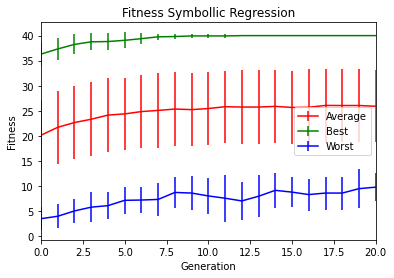

In [35]:
#plot statistics:
x = np.arange(0, MAX_GENERATIONS+1)
avgArray = np.array(avgListFitness)
stdArray = np.array(stdListFitness)
minArray = np.array(minListFitness)
maxArray = np.array(maxListFitness)

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Symbollic Regression')
plt.errorbar(x, -avgArray.mean(0), yerr=-stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, -minArray.mean(0), yerr=-minArray.std(0),label="Best", color="Green")
plt.errorbar(x, -maxArray.mean(0), yerr=-maxArray.std(0),label="Worst", color="Blue")
plt.xlim([0, 20])
plt.legend()
plt.show()

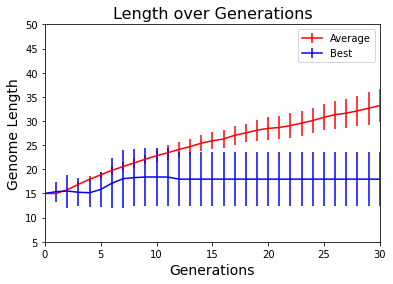

In [40]:
x = np.arange(0, MAX_GENERATIONS+1)
avgSizeArray = np.array(avgListSize)
bestSizeArray = np.array(bestListSize)
maxSizeArray = np.array(maxListSize)


plt.errorbar(x, avgSizeArray.mean(0), yerr=avgSizeArray.std(0),label="Average",color="Red")
# plt.errorbar(x, maxSizeArray.mean(0), yerr=maxSizeArray.std(0), label="Max", color="Green")
plt.errorbar(x, bestSizeArray.mean(0), yerr=bestSizeArray.std(0), label="Best", color="Blue")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Length over Generations', fontsize=16)
plt.legend()
plt.xlim([0, 30])
plt.ylim([5, 50])
plt.show()